In [67]:
import warnings

import matplotlib as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import (CatBoostEncoder, CountEncoder, OneHotEncoder,
                               OrdinalEncoder, TargetEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')

In [27]:
RANDOM_STATE = np.random.seed(42)

In [28]:
df = pd.read_csv('../data/interim/data.csv')

In [30]:
# разбиваем датасет на валидационный и основной
val = df[df['salary_mean'] != df['salary_mean']]
df = df.dropna(subset=['salary_mean'])

<AxesSubplot: >

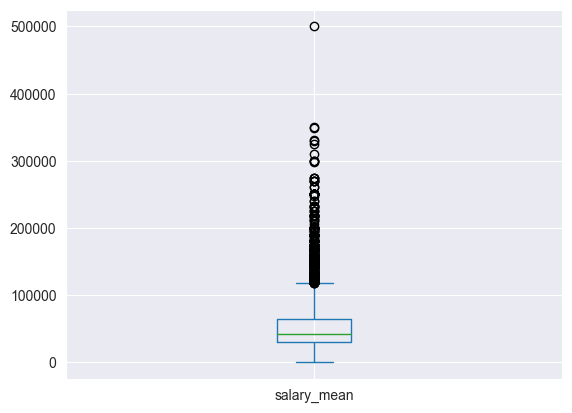

In [31]:
# смотрим статистику по таргету
df['salary_mean'].plot(kind='box')

In [32]:
# удалим аномально высокие зарплаты
df = df[(np.abs(stats.zscore(df[['salary_mean']])) < 3).all(axis=1)]

In [34]:
# обозначаем текстовые признаки
text_cols = ['description', 'key_skills', 'name', 'spec_area', 'prof_role','employer_name']

In [35]:
# удаляем текстовые признаки
df = df.drop(columns=text_cols)
val = val.drop(columns=text_cols)

In [36]:
# смотрим кардинальность признаков

df.select_dtypes(object).nunique()

address_city         745
area_name            797
billing_type_name      3
department_name       86
employment_name        4
experience_name        4
languages             15
salary_gross           2
schedule_name          5
type_name              3
metro                124
driver_license        25
dtype: int64

In [37]:
# обозначаем высококардинальные признаки
highcord_cols = [
    'address_city',
    'area_name',
    'department_name',
    'languages',
    'metro',
    'driver_license']

In [38]:
for col in highcord_cols:
    print(col, df[col].nunique())

address_city 745
area_name 797
department_name 86
languages 15
metro 124
driver_license 25


In [39]:
# обозначаем оставшиеся категориальные признаки
cat_cols = df.select_dtypes(exclude='float64').columns.to_list()
cat_cols = list(set(cat_cols) - set(highcord_cols) -set(text_cols))

In [40]:
for col in cat_cols:
    print(col, df[col].nunique())

has_test 2
salary_gross 2
experience_name 4
response_letter_required 2
accept_temporary 2
accept_incomplete_resumes 2
accept_handicapped 2
type_name 3
working_days 2
allow_messages 2
schedule_name 5
working_time_intervals 2
accept_kids 2
employer_trusted 2
billing_type_name 3
employment_name 4
premium 2


In [41]:
# обозначаем числовые признаки
num_cols = ['address_lat', 'address_lng']

In [42]:
# делим на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['salary_mean']), df[['salary_mean']],
    shuffle=True,train_size=0.8)  

In [43]:
# создаем пайплайны преобразования признаков
num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy="most_frequent")),
        ('scale', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ("encode", TargetEncoder()),
        ('impute', SimpleImputer(strategy="most_frequent")),
        ('scale', StandardScaler()),
    ])

highcord_pipline = Pipeline([
        ("encode", CountEncoder()),
        ('impute', SimpleImputer(strategy="most_frequent")),
        ('scale', StandardScaler()),
    ])

In [44]:
# создаем трансофрмер преобразования признаков из пайплайнов
preprocesser = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
        ("hc", highcord_pipline, highcord_cols),
        ])

In [45]:
# обьявляем модель
model = RidgeCV()

In [46]:
# собирам пайплайн трансформирования данных и обучения модели
pipeline = Pipeline(steps=[
    ("preprocesser", preprocesser),
    ("classifier", model),
])

In [47]:
# создаем грид для подбора способов предобработки данных
param_grid = [
    {
        "preprocesser__num__impute__strategy": ["mean", "median"],
        "preprocesser__num__scale": [StandardScaler(), MinMaxScaler(), Normalizer()],
        "preprocesser__cat__encode": [OneHotEncoder(), OrdinalEncoder(), CatBoostEncoder()],
        "preprocesser__hc__encode": [OneHotEncoder(), OrdinalEncoder(), CatBoostEncoder()],
    },]

In [48]:
# обьявляем грид серч по заданной модели 
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,)

In [49]:
grid_search

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocesser',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['address_lat',
                                                                          'address_lng']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encode',
                                                                                          TargetEncoder()),
                                                                                         ('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('scale',
                                                                                          StandardScaler...
                                       ('classifier', RidgeCV())]),
             n_jobs=-1,
             param_grid=[{'preprocesser__cat__encode': [OneHotEncoder(),
                                                        OrdinalEncoder(),
                                                        CatBoostEncoder()],
                          'preprocesser__hc__encode': [OneHotEncoder(),
                                                       OrdinalEncoder(),
                                                       CatBoostEncoder()],
                          'preprocesser__num__impute__strategy': ['mean',
                                                                  'median'],
                          'preprocesser__num__scale': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       Normalizer()]}],
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(X_train, y_train)

In [51]:
# смотрим на результат по метрике rmse
print(f"Best params:")
print(grid_search.best_params_)
print("Best score in grid search:")
print(f"{np.sqrt(-grid_search.best_score_):.2f}")
print("best logistic regression from grid search:")
print(f"{np.sqrt(-grid_search.score(X_test, y_test)):.2f}")

Best params:
{'preprocesser__cat__encode': OneHotEncoder(), 'preprocesser__hc__encode': CatBoostEncoder(), 'preprocesser__num__impute__strategy': 'median', 'preprocesser__num__scale': Normalizer()}
Best score in grid search:
23059.70
best logistic regression from grid search:
22105.06


In [59]:
y_test_pred = grid_search.predict(X_test)
lin_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

(0.0, 200000.0)

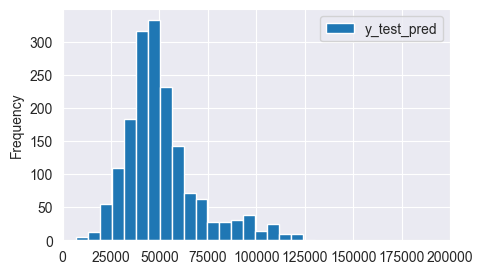

In [73]:
pd.DataFrame(y_test_pred, columns=['y_test_pred']).plot(kind='hist', figsize=(5,3),bins=20)
plt.pyplot.xlim(0,200*10**3)

In [60]:
y_val_pred = grid_search.predict(val)

(0.0, 200000.0)

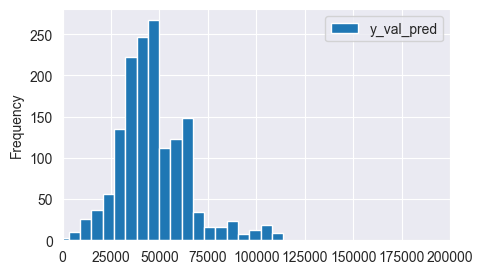

In [75]:
pd.DataFrame(y_val_pred,columns=['y_val_pred']).plot(kind='hist', figsize=(5,3), bins=20)
plt.pyplot.xlim(0,200*10**3)